# Law, Bias, and Algorithms
## Algorithmic fairness (2/2)

Today, we will continue building and evaluating our own risk assessment tool using the COMPAS data to examine some other aspects of fairness.

Just to recap what's in the data and what was the model we built:

In [75]:
# Some initial setup
options(digits = 3)
library(tidyverse)

theme_set(theme_bw())

# Because huge plots are ugly
options(repr.plot.width = 6, repr.plot.height = 4)

# Read the data
compas_df <- read_rds("../data/compas.rds")

# Recap the model
recid_model <- glm(is_recid ~ priors_count + age, data = compas_df, family = "binomial")
compas_df <- compas_df %>%
    mutate(
        risk = predict(recid_model, type = "response"),
        predicted_risk_score = round(risk * 10),
        pred_recid = risk >= 0.5
    )

## COMPAS data revisited

A cleaned version of the COMPAS data is loaded as `compas_df`, with the following columns

* `id`: unique identifiers for each case
* `sex`, `dob`, `age`, `race`: demographic information for each defendant
* `recid_score`, `violence_score`: COMPAS scores assessing risk that a defendant will recidivate (`violence_score` for violent crimes) within two years of release (higher score correspond to higher risk)
* `priors_count`: number of prior arrests
* `is_recid`, `is_violent_recid`: Indicator variable that is `1` if the defendant was arrested for a new (violent) crime within two years of release, and `0` otherwise.

In [47]:
head(compas_df)

id,sex,dob,age,race,recid_score,violence_score,priors_count,is_recid,is_violent_recid,risk,predicted_risk_score
<dbl>,<chr>,<date>,<dbl>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
3,Male,1982-01-22,34,African-American,3,1,0,1,1,0.365,4
4,Male,1991-05-14,24,African-American,4,3,4,1,0,0.641,6
5,Male,1993-01-21,23,African-American,8,6,1,0,0,0.535,5
8,Male,1974-07-23,41,Caucasian,6,2,14,1,0,0.800,8
10,Female,1976-06-03,39,Caucasian,1,1,0,0,0,0.311,3
13,Male,1994-06-10,21,Caucasian,3,5,1,1,1,0.559,6


### Exercise 1: Calibration by gender

In [48]:
# Calculate discretized risk score
# group people with risk score equal or gretaer than 8

calibration_by_gender <- compas_df %>%
# WRITE CODE HERE
# START solution
    mutate(predicted_risk_score = ifelse(predicted_risk_score >= 8, 8, predicted_risk_score)) %>%
    group_by(sex, predicted_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))
# END solution

# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate)

predicted_risk_score,Female,Male
<dbl>,<dbl>,<dbl>
1,0.125,0.158
2,0.164,0.237
3,0.247,0.309
4,0.312,0.395
5,0.363,0.486
6,0.632,0.683
7,0.759,0.767
8,0.789,0.820


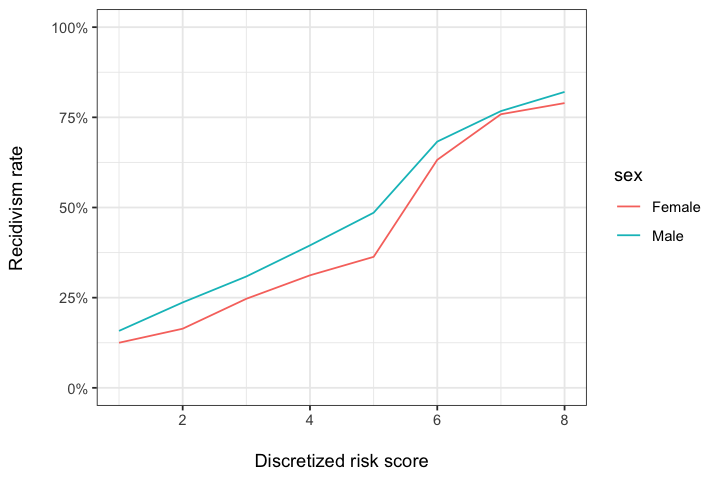

In [49]:
# Calibration plot
ggplot(calibration_by_gender, 
       aes(x = predicted_risk_score, y = recidivism_rate, color = sex)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 8, 2), limits = c(1, 8))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

### Exercise 2: Relibrate the model by including gender

In [88]:
# Refit the model by including gender

# WRITE CODE HERE
# START solution
recid_gender_model <- glm(is_recid ~ priors_count + age + sex, data = compas_df, family = "binomial")
compas_df <- compas_df %>%
    mutate(
        gender_aware_risk = predict(recid_gender_model, type = "response"),
        gender_aware_risk_score = round(gender_aware_risk * 10)
    )
# END solution

In [89]:
calibration_by_gender <- compas_df %>%
    mutate(gender_aware_risk_score = ifelse(gender_aware_risk_score >= 8, 8, gender_aware_risk_score)) %>%
    group_by(sex, gender_aware_risk_score) %>%
    summarize(recidivism_rate = mean(is_recid))

# Put the recidivism rates of different races side by side
calibration_by_gender %>%
    spread(sex, recidivism_rate)

gender_aware_risk_score,Female,Male
<dbl>,<dbl>,<dbl>
1,0.164,0.155
2,0.235,0.232
3,0.262,0.310
4,0.340,0.373
5,0.550,0.447
6,0.754,0.658
7,0.789,0.750
8,0.794,0.821


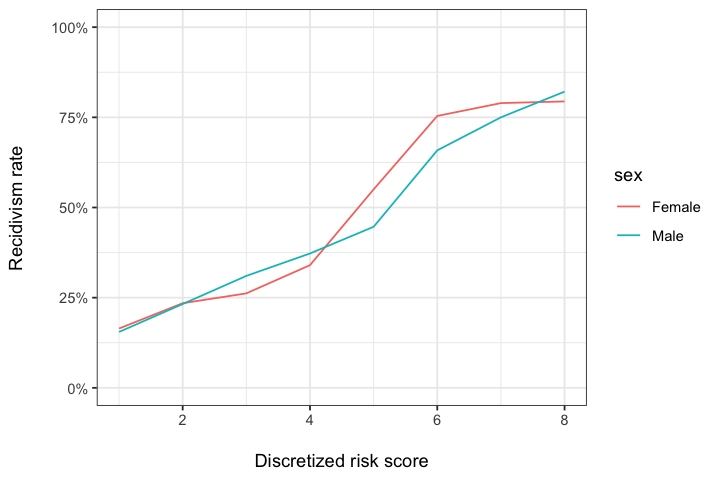

In [90]:
# Calibration plot
ggplot(calibration_by_gender, 
       aes(x = gender_aware_risk_score, y = recidivism_rate, color = sex)) +
    geom_line() + 
    scale_y_continuous(labels = scales::percent_format(1), limits = c(0, 1))+
    scale_x_continuous(breaks = seq(0, 8, 2), limits = c(1, 8))+
    labs(x = "\nDiscretized risk score",
         y = "Recidivism rate\n")

### Exercise 3: Compare gender-aware and gender-blind models

In [94]:
compas_df %>%
    mutate(
        detained = risk > 0.5,
        gender_aware_detained = gender_aware_risk > 0.5
    ) %>%
    summarize(
        n_female_detained = sum(detained & (sex == "Female")),
        n_female_gender_aware_detained = sum(gender_aware_detained & (sex == "Female"))
    )

n_female_detained,n_female_gender_aware_detained
<int>,<int>
473,220


### Exercise 4: False positive rate and false negative rate

We now introduce some additional common metrics for evaluating model performance.

We define the following terms:

* P: the number of real positive cases in the data
* N: the number of real negative cases in the data
* TP: true positives; the number of predicted positive cases that were real positives 
* TN: true negatives; the number of predicted negative cases that were real negatives 
* FP: false positives; the number of predicted positives that were actually negative in the data (false alarms, Type I error)
* FN: false negatives; the number of predicted negatives that were actually positive in the data (Type II error) 

Their definitions can be illustrated using following table:


| <div></div> | Real positive | Real negative |
|--------------------|---------------|---------------|
| Predicted positive |       TP      |            FP |
| Predicted negative |       FN      |            TN |


The the false positive rate (FPR) is given by: 

\begin{equation}
  FPR = \frac{FP}{N} = \frac{FP}{FP + TN}
\end{equation}

Similarly, the false negative rate (FNR) is given by: 

\begin{equation}
  FNR = \frac{FN}{P} = \frac{FN}{TP + FN}
\end{equation}


In [78]:
calc_fpr_fnr <- function(df) {
    df %>%
        group_by(race) %>%
        summarize(
            fp = sum((is_recid == 0) & (pred_recid)),
            fn = sum((is_recid == 1) & (!pred_recid)),
            positives = sum(is_recid),
            negatives = sum(!is_recid),
            fpr = fp/negatives,
            fnr = fn/positives
        ) %>%
        select(race, fpr, fnr)
}

calc_fpr_fnr(compas_df)

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.413,0.240
Caucasian,0.228,0.487


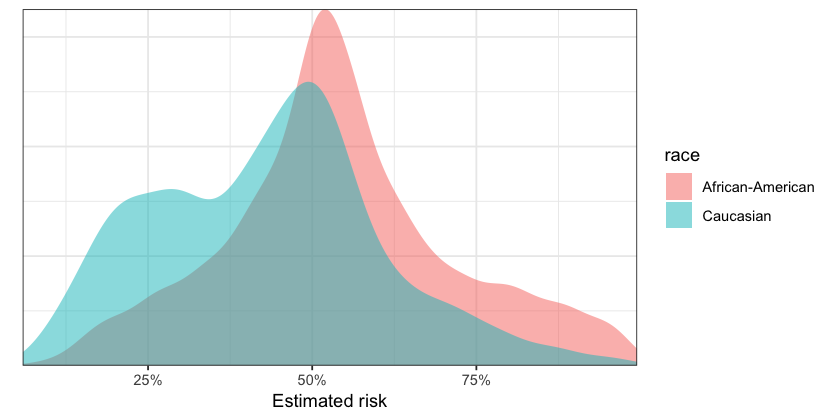

In [64]:
# Recall this risk distribution plot
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(1), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())

### Exercise 5: Equalizing false positive rates

In [85]:
black_threshold = 0.5
white_threshold = 0.5

# WRITE CODE HERE
# START solution
black_threshold = 0.555
# END solution

# Calculate detention and recidivism rate by race
compas_df %>%
    mutate(pred_recid = risk > if_else(race == "Caucasian", white_threshold, black_threshold)) %>%
    calc_fpr_fnr()

race,fpr,fnr
<chr>,<dbl>,<dbl>
African-American,0.228,0.414
Caucasian,0.228,0.487


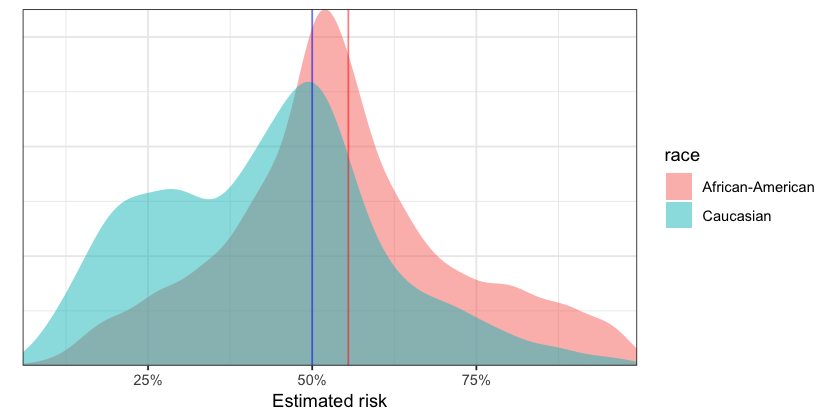

In [110]:
# See where the thresholds are on the risk distribution
options(repr.plot.width = 7, repr.plot.height = 3.5)
ggplot(compas_df, aes(x = risk, fill = race)) +
    geom_density(alpha = 0.5, color = NA) +
    scale_x_continuous("Estimated risk", labels = scales::percent_format(1), expand = c(0, 0)) +
    scale_y_continuous(element_blank(), expand = c(0, 0)) +
    theme(axis.ticks.y = element_blank(),
          axis.text.y = element_blank())+
    geom_vline(
        xintercept = c(black_threshold, white_threshold), 
        color = c("red", "blue"),
        alpha = 0.5
    )